In [4]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
from mpi4py import MPI
import pickle


# torch
import torch
import torch.nn as nn

# quimb
import quimb.tensor as qtn
import autoray as ar

from vmc_torch.experiment.tn_model import *
from vmc_torch.sampler import MetropolisExchangeSamplerSpinful_2D_reusable
from vmc_torch.variational_state import Variational_State
# from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.fermion_utils import generate_random_fpeps
from vmc_torch.utils import closest_divisible

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(8)
Ly = int(8)
symmetry = 'Z2'
t = 1.0
U = 8.0
N_f = int(Lx*Ly)
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice_torch(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 12
chi = 144
dtype=torch.float64

# Load PEPS
pwd = '/pscratch/sd/s/sijingdu/VMC/fermion/data'
try:
    skeleton = pickle.load(open(f"{pwd}/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
    peps_params = pickle.load(open(f"{pwd}/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
    peps = qtn.unpack(peps_params, skeleton)
except:
    peps = generate_random_fpeps(Lx, Ly, D=D, seed=42, symmetry=symmetry, Nf=N_f, spinless=False)[0]
peps.exponent = 0
peps.apply_to_arrays(lambda x: torch.tensor(2*x, dtype=dtype))
for ts in peps.tensors:
    ts.data.phase_sync(inplace=True)

# VMC sample size
N_samples = 2
N_samples = closest_divisible(N_samples, SIZE)

In [5]:
model.num_params

21632

In [2]:
model = fTNModel_reuse(peps, max_bond=chi, dtype=dtype, debug=True)
# model = fTNModel(peps, max_bond=chi, dtype=dtype)

sampled_x = torch.tensor([2., 1., 2., 1., 2., 0., 3., 1., 1., 2., 3., 0., 1., 2., 1., 1., 2., 1.,
        1., 0., 2., 2., 1., 2., 1., 0., 3., 3., 2., 2., 2., 2., 1., 2., 2., 1.,
        1., 2., 1., 3., 2., 2., 0., 3., 0., 1., 0., 1., 2., 1., 2., 1., 3., 1.,
        2., 1., 1., 2., 1., 1., 2., 1., 2., 2.], dtype=torch.float64)
# sampled_x = torch.tensor(H.hilbert.random_state())

sampler = MetropolisExchangeSamplerSpinful_2D_reusable(H.hilbert, graph, N_samples=N_samples, burn_in_steps=1, reset_chain=False, random_edge=False, equal_partition=False, dtype=dtype)
# sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=10, reset_chain=False, random_edge=False, equal_partition=False, dtype=dtype)
vstate = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
# t0 = time.time()
sampled_x, sampled_amp = sampler._sample_next(vstate, burn_in=False)
vstate.set_cache_env_mode(on=True)
amp, grad = vstate.amplitude_grad(sampled_x, retain_graph=True)
amp00 = amp
vstate.set_cache_env_mode(on=False)
# t1 = time.time()

# model.zero_grad()
# model.get_grad()
# grad_hole = model.params_grad_to_vec()/amp00

# if not torch.allclose(grad_hole, grad):
#     print(amp)
#     print("Gradients do not match!")
#     print(grad.norm(), grad_hole.norm())
#     print((grad-grad_hole).abs().max())

Reused Amp val: 6.989391425324388e-10, Exact Amp val: 6.989391434292138e-10, Rel error: 1.283051528638725e-09


In [6]:
model.from_1d_to_2d(sampled_x)

tensor([[0., 2., 2., 3., 3., 1., 1., 1.],
        [2., 3., 1., 0., 0., 2., 2., 2.],
        [2., 3., 2., 2., 2., 1., 2., 1.],
        [1., 0., 1., 1., 1., 2., 0., 2.],
        [1., 2., 2., 2., 1., 1., 3., 1.],
        [1., 1., 1., 3., 0., 2., 0., 3.],
        [2., 2., 3., 0., 1., 2., 2., 2.],
        [1., 0., 1., 3., 1., 2., 1., 1.]], dtype=torch.float64)

In [ ]:
from quimb.tensor.tensor_2d import Rotator2D
row_id = 3
from_which = 'xmin'  # 'xmax', 'xmin', 'ymax', 'ymin'
amp_tn = model.get_amp_tn(sampled_x)
row_tn = amp_tn.select(amp_tn.x_tag(row_id))
def get_cache_key(config, from_which, row_id=None, col_id=None):
    if row_id is None and col_id is None:
        raise ValueError("Either row_id or col_id must be provided")
    if row_id is not None:
        assert from_which in ['xmax', 'xmin'], "from_which must be 'xmax' or 'xmin' when row_id is provided"
        config_2d = model.from_1d_to_2d(config)
        rows_config = tuple(torch.cat(tuple(config_2d[row_id+1:].to(torch.int))).tolist()) if from_which=='xmax' else tuple(torch.cat(tuple(config_2d[:row_id].to(torch.int))).tolist())
        return (from_which, rows_config)
    if col_id is not None:
        assert from_which in ['ymax', 'ymin'], "from_which must be 'ymax' or 'ymin' when col_id is provided"
        config_2d = model.from_1d_to_2d(config)
        cols_config = tuple(torch.cat(tuple(config_2d[:, col_id+1:].to(torch.int))).tolist()) if from_which=='ymax' else tuple(torch.cat(tuple(config_2d[:, :col_id].to(torch.int))).tolist())
        return (from_which, cols_config)

cache_mps = model.env_x_cache[get_cache_key(sampled_x, from_which, row_id=row_id)]
new_cache_key = get_cache_key(sampled_x, from_which, row_id=row_id+1)
mpo_mps_tn = (row_tn | cache_mps)
new_cache_mps = mpo_mps_tn.contract_boundary_from(from_which=from_which, xrange=(0, Lx-1), yrange=(0, Ly-1), max_bond=chi, mode='mps', cutoff=0.0)

(new_cache_mps|model.env_x_cache[get_cache_key(sampled_x, 'xmax', row_id=row_id)]).contract()

tensor(6.3826e-10, dtype=torch.float64, grad_fn=<MulBackward0>)

In [29]:
from vmc_torch.fermion_utils import flatten_fts_params
from vmc_torch.fermion_utils import reconstruct_fts_params
model.clear_grad()
amp_tn = model.get_amp_tn(sampled_x)
cached_grad = []
max_g = 0
index_map = {0: 0, 1: 1, 2: 1, 3: 0}
for tid, model_ts_params in model.torch_tn_params.items():
    # utils numbers
    site_2d = model.from_1dsite_to_2dsite(int(tid))
    p_ind = model.skeleton.site_ind_id.format(*site_2d)
    p_ind_order = model.skeleton.tensor_map[int(tid)].inds.index(p_ind)
    on_site_config = int(sampled_x[int(tid)])
    on_site_config_parity = index_map[on_site_config]
    site_tag = model.skeleton.site_tag_id.format(*site_2d)

    ts0 = amp_tn.select(site_tag).contract()
    ts_params = ts0.get_params()

    ts_left = [ts for ts in amp_tn.tensors if site_tag not in ts.tags]
    tn_left = qtn.TensorNetwork(ts_left)
    grad_ts = tn_left.contract()
    grad_ts.data.phase_sync(inplace=True) 
    # BUG: should take into account the fermion signs generated in the final contraction!!
    # TODO: deal with the proper fermion signs
    # the absolute value of the grad is correct

    grad_ts_params = grad_ts.get_params()
    # ts_params keys ordering may differ from the model parameters keys ordering!! model_ts_params.keys() are in lexicographic order. Use sorted(ts_params) to ensure the order is the same.
    for blk in sorted(ts_params):
        if blk in grad_ts_params:
            ts_params[blk].grad = grad_ts_params[blk]
            cached_grad.append(grad_ts_params[blk]/amp00)
            max_g = max(max_g, torch.max(torch.abs(grad_ts_params[blk]/amp00)))
cached_grad_norm_list = torch.tensor([torch.norm(a) for a in cached_grad])
print('Max grad:', max_g)

KeyboardInterrupt: 

In [13]:
# Gradient calculation via digging holes in the TN.
# TODO: Manually tracking the fermion signs is a bit tricky, so a clever workaround is to run a tiny backpropagation program on the final contraction.
# Matching the params is the key!!

model.zero_grad()
index_map = {0: 0, 1: 1, 2: 1, 3: 0}
array_map = {
    0: torch.tensor([1.0, 0.0]),
    1: torch.tensor([1.0, 0.0]),
    2: torch.tensor([0.0, 1.0]),
    3: torch.tensor([0.0, 1.0])
}
grad_vec_hole = []
config_2d = model.from_1d_to_2d(sampled_x)
print(config_2d)
for tid, model_ts_params in model.torch_tn_params.items():
    # utils numbers
    site_2d = model.from_1dsite_to_2dsite(int(tid))
    
    p_ind = model.skeleton.site_ind_id.format(*site_2d)
    p_ind_order = model.skeleton.tensor_map[int(tid)].inds.index(p_ind)
    on_site_config = int(sampled_x[int(tid)])
    on_site_config_parity = index_map[on_site_config]
    site_tag = model.skeleton.site_tag_id.format(*site_2d)
    input_vec = array_map[on_site_config]

    ts0 = amp_tn.select(site_tag).contract()
    ts_params = ts0.get_params()

    # Reuse cached environment to compute grad_ts
    row_id = site_2d[0]
    col_id = site_2d[1]
    # select the cached_env on both sides of the site tensor along the row
    rows_above = list(range(row_id+1, model.Lx))
    rows_below = list(range(0, row_id))
    # print('Rows above:', rows_above)
    # print('Rows below:', rows_below)
    cached_amp_tn_above = model.env_x_cache[('xmax', tuple(torch.cat(tuple(config_2d[rows_above].to(torch.int))).tolist()))] if rows_above else qtn.TensorNetwork([])
    cached_amp_tn_below = model.env_x_cache[('xmin', tuple(torch.cat(tuple(config_2d[rows_below].to(torch.int))).tolist()))] if rows_below else qtn.TensorNetwork([])
    within_row_sites = list((site_2d[0], col_id) for col_id in range(model.Ly) if col_id != site_2d[1])
    within_row_hole_tn = model.get_local_amp_tensors(within_row_sites, config=sampled_x)
    grad_ts = (within_row_hole_tn | cached_amp_tn_above | cached_amp_tn_below).contract()

    # Exact contraction of the TN without the site tensor, naive calculation, expensive baseline.
    ts_left = [ts for ts in amp_tn.tensors if site_tag not in ts.tags]
    tn_left = qtn.TensorNetwork(ts_left)
    # grad_ts = tn_left.contract()


    grad_ts.data.phase_sync(inplace=True)
    # BUG: should take into account the fermion signs generated in the final contraction!!
    # TODO: deal with the proper fermion signs
    # the absolute value of the grad is correct
    # Workaround: use a tiny backpropagation program to calculate the gradient of the final exact contraction.


    ts0.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype, requires_grad=True))
    grad_ts.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype, requires_grad=False))
    amp_temp = (ts0|grad_ts).contract()
    amp_temp.backward()

    grad_ts_backprop_params = ts0.get_params().copy() # correct gradients
    for blk, ts_temp in ts0.get_params().items():
        grad_ts_backprop_params[blk] = ts_temp.grad

    grad_ts_params = grad_ts.get_params()

    # print(grad_ts_params)
    # print(grad_ts_backprop_params)

    # select the remaining sectors in model_ts_params
    remaining_sliced_sectors = [sector for sector in sorted(ts_params)]
    remaining_sectors = [sector + (on_site_config_parity,) for sector in sorted(ts_params)]
    # print('Remaining sectors:', remaining_sectors)

    for sliced_blk, blk in zip(remaining_sliced_sectors, remaining_sectors):
        # print(sliced_blk, blk)
        data = model_ts_params[str(blk)]
        select_index = torch.argmax(input_vec).item()
        slicer = [slice(None)] * data.ndim
        slicer[p_ind_order] = select_index
        reconstructed_grad_tensor = torch.zeros_like(data)
        # reconstructed_grad_tensor[tuple(slicer)] = grad_ts_params[sliced_blk]
        reconstructed_grad_tensor[tuple(slicer)] = grad_ts_backprop_params[sliced_blk]
        # print(reconstructed_grad_tensor)
        grad_vec_hole.append((blk, reconstructed_grad_tensor/amp00))
        data.grad = reconstructed_grad_tensor
    
    # print(ts0.data, grad_ts.data)

    # break

print('Max grad:', max([torch.max(torch.abs(a)) for _, a in grad_vec_hole]))
model_grad_vec_hole = model.params_grad_to_vec()
# model.params_grad_to_vec().norm()
model_grad_vec_hole.norm()

tensor([[3, 1, 1, 0, 1, 2, 2, 0],
        [2, 3, 1, 1, 2, 2, 3, 2],
        [2, 3, 2, 0, 1, 3, 3, 2],
        [2, 1, 1, 1, 0, 3, 0, 2],
        [3, 1, 1, 3, 0, 2, 1, 3],
        [1, 0, 0, 0, 2, 3, 0, 0],
        [0, 1, 1, 0, 3, 3, 2, 2],
        [3, 3, 3, 0, 0, 2, 1, 0]])


/tmp/ipykernel_916492/828194745.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts0.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype, requires_grad=True))
/tmp/ipykernel_916492/828194745.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_ts.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype, requires_grad=False))


Max grad: tensor(28.1213, dtype=torch.float64, grad_fn=<MaxBackward1>)


tensor(0.3365, dtype=torch.float64)

In [18]:
# Baseline gradient calculation
model.clear_grad()

amp_tn = model.get_amp_tn(sampled_x, reconstruct=True)
# ts0 = amp_tn.select(site_tag).contract()
# ts_left = [ts for ts in amp_tn.tensors if site_tag not in ts.tags]
# tn_left = qtn.TensorNetwork(ts_left)
# grad_ts0 = tn_left.contract()
# amp_val = (ts0|grad_ts0).contract()
amp_val = amp_tn.contract()

amp_val.backward(retain_graph=True)
grad_vec0 = []
for name, param in model.named_parameters():
    if param.grad is None:
        ...
    else:
        # print(param.grad/amp_val)
        grad_vec0.append((name, param.grad/amp_val))
        # grad_vec0.append(param.grad)

model_grad_vec_autodiff = model.params_grad_to_vec()
model.clear_grad()
# grad_vec0
# print(model.get_amp_tn(sampled_x).contract())
max_g = 0
max_grad_ts = None
for name, grad_ts in grad_vec0:
    if grad_ts is not None:
        max_g = max(max_g, torch.max(torch.abs(grad_ts)))
        # print(torch.norm(grad_ts))
        if max_grad_ts is None or torch.max(torch.abs(grad_ts)) > torch.max(torch.abs(max_grad_ts)):
            max_grad_ts = grad_ts

print('Max grad:', max_g)

autodiff_grad_norm_list = torch.tensor([torch.norm(a) for _, a in grad_vec0])
model_grad_vec_autodiff.norm()

Max grad: tensor(28.1213, dtype=torch.float64, grad_fn=<MaxBackward1>)


tensor(0.3365, dtype=torch.float64)

In [21]:
(model_grad_vec_hole - model_grad_vec_autodiff).norm()

tensor(5.7422e-14, dtype=torch.float64)

In [39]:
for i in range(len(grad_vec0)):
    tensor_benchmark = grad_vec0[i][1]
    hole_tensor = grad_vec_hole[i][1]
    # print(grad_vec0[i][0], grad_vec_hole[i][0])
    # print(torch.allclose(tensor_benchmark, hole_tensor, rtol=1e-10, atol=1e-10))
    if not torch.allclose(tensor_benchmark, hole_tensor, rtol=1e-10, atol=1e-10):
        print('Diff:', torch.norm(tensor_benchmark-hole_tensor))#<torch.norm(tensor_benchmark)*1e-2)

In [15]:
# Approximate gradient calculation
model.clear_grad()
config_2d = model.from_1d_to_2d(sampled_x)
# model._env_x_cache = None
# model._env_y_cache = None
model.cache_env_mode = True
amp0 = model(sampled_x)
key_bot = ('xmax', tuple(torch.cat(tuple(config_2d[model.Lx//2:].to(torch.int))).tolist()))
key_top = ('xmin', tuple(torch.cat(tuple(config_2d[:model.Lx//2].to(torch.int))).tolist()))
amp_bot = model.env_x_cache[key_bot]
amp_top = model.env_x_cache[key_top]
amp_val = (amp_bot|amp_top).contract()*10**(model.skeleton.exponent)
amp_val.backward(retain_graph=True)
# amp0.backward(retain_graph=True)

# model.clear_grad()
# amp_tn = model.get_amp_tn(sampled_x)
# amp = amp_tn.contract_boundary_from_xmin(max_bond=model.max_bond, cutoff=0.0, xrange=[0, model.Lx//2-1])
# amp = amp.contract_boundary_from_xmax(max_bond=model.max_bond, cutoff=0.0, xrange=[model.Lx//2, model.Lx-1])
# amp_val1 = amp.contract()
# amp_val1.backward(retain_graph=True)

grad_vec1 = []
for param in model.parameters():
    if param.grad is None:
        # print(None)
        ...
    else:
        # print(param.grad/amp0)
        grad_vec1.append(param.grad/amp00)

model.clear_grad()
max_g = 0
for grad_ts in grad_vec1:
    if grad_ts is not None:
        max_g = max(max_g, torch.max(torch.abs(grad_ts)))
print('Max grad:', max_g)

autodiff_approx_grad_norm_list = torch.tensor([torch.norm(a) for a in grad_vec1])

Reused Amp val: -2.251915407795547, Exact Amp val: -2.2519154077955466, Rel error: 1.9720510295934789e-16
Max grad: tensor(9.5086, dtype=torch.float64, grad_fn=<MaxBackward1>)


In [16]:
# compare the cached gradient norm and the autodiff gradient norm
for i in range(len(cached_grad)):
    print(f'Exact contraction/hole tn: All close? {torch.allclose(cached_grad_norm_list[i], autodiff_grad_norm_list[i], rtol=1e-5, atol=1e-5)}')
    # if not torch.allclose(cached_grad_norm_list[i], autodiff_grad_norm_list[i], rtol=1e-5, atol=1e-5):
    #     print(cached_grad_norm_list[i], autodiff_grad_norm_list[i])
    # print(f'Approx contraction/hole tn: All close? {torch.allclose(cached_grad_norm_list[i], autodiff_approx_grad_norm_list[i], rtol=1e-5, atol=1e-5)}')

Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contraction/hole tn: All close? True
Exact contr

In [17]:
print(torch.allclose(amp0, amp_val))
mean_grad_vec0_norm = torch.mean(autodiff_grad_norm_list)
mean_grad_vec1_norm = torch.mean(autodiff_approx_grad_norm_list)
print(mean_grad_vec0_norm, mean_grad_vec1_norm)
for i in range(len(grad_vec1)):
    # show rel err in percentage
    rel_err = torch.norm(grad_vec0[i][1]-grad_vec1[i])/torch.norm(grad_vec0[i][1])
    
    if rel_err > 1:
        print(f'grad_vec0[{i}]-grad_vec1[{i}]: {rel_err * 100:.2f}%')
        print(f'grad_vec0[{i}] norm: {torch.norm(grad_vec0[i][1])}, absolute ratio: {torch.norm(grad_vec0[i][1])/mean_grad_vec0_norm}')
        print(f'grad_vec1[{i}] norm: {torch.norm(grad_vec1[i])}, absolute ratio: {torch.norm(grad_vec1[i])/mean_grad_vec1_norm}\n')

True
tensor(1.2908, dtype=torch.float64) tensor(1.2925, dtype=torch.float64)
grad_vec0[9]-grad_vec1[9]: 9893268798.21%
grad_vec0[9] norm: 3.1037462359190757e-10, absolute ratio: 2.404559121780802e-10
grad_vec1[9] norm: 0.030706195793417202, absolute ratio: 0.023756621162918715

grad_vec0[11]-grad_vec1[11]: 185.65%
grad_vec0[11] norm: 0.005452882976893784, absolute ratio: 0.004224501136836841
grad_vec1[11] norm: 0.011498515030139784, absolute ratio: 0.008896115537884998

grad_vec0[13]-grad_vec1[13]: 180170261.76%
grad_vec0[13] norm: 1.4184821551802635e-16, absolute ratio: 1.0989378467379716e-16
grad_vec1[13] norm: 2.5556830311037194e-10, absolute ratio: 1.9772684962637681e-10

grad_vec0[18]-grad_vec1[18]: 1774.51%
grad_vec0[18] norm: 7.808938947831837e-11, absolute ratio: 6.049803673101578e-11
grad_vec1[18] norm: 1.3879054490441033e-09, absolute ratio: 1.0737879802733453e-09

grad_vec0[19]-grad_vec1[19]: 51194973525.37%
grad_vec0[19] norm: 7.301911146376855e-18, absolute ratio: 5.656995

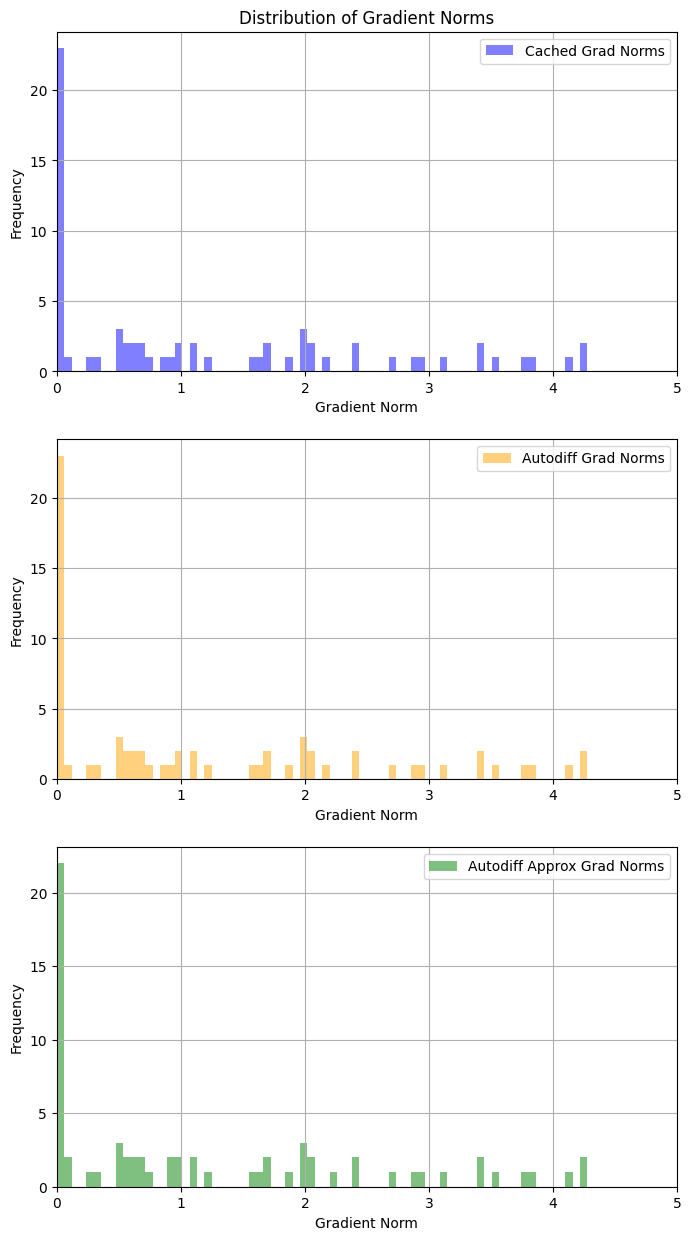

In [26]:
# plot the grad tensor norms distribution and compare
import matplotlib.pyplot as plt
# use 3 subplots to show the distribution of the gradient norms
fig, ax = plt.subplots(3, 1, figsize=(8, 15))

# restrict the x-axis to the range of [0, 5]
for a in ax:
    a.set_xlim(0, 5)

ax[0].hist(cached_grad_norm_list.numpy(), bins=200, alpha=0.5, label='Cached Grad Norms', color='blue')
ax[1].hist(autodiff_grad_norm_list.numpy(), bins=200, alpha=0.5, label='Autodiff Grad Norms', color='orange')
ax[2].hist(autodiff_approx_grad_norm_list.numpy(), bins=200, alpha=0.5, label='Autodiff Approx Grad Norms', color='green')

ax[0].set_xlabel('Gradient Norm')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Gradient Norms')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('Gradient Norm')
ax[1].set_ylabel('Frequency')
# ax[1].set_title('Distribution of Gradient Norms')
ax[1].legend()
ax[1].grid()

ax[2].set_xlabel('Gradient Norm')
ax[2].set_ylabel('Frequency')
# ax[2].set_title('Distribution of Gradient Norms')
ax[2].legend()
ax[2].grid()

plt.show()

In [9]:
average_rel_err = 0.0
for rel_contraction_err in model.debug_amp_cache:
    average_rel_err += rel_contraction_err[2]
average_rel_err /= len(model.debug_amp_cache)
# print(f"Average relative contraction error: {average_rel_err} for D={D}, chi={chi}, time={t1-t0:.2f}s, Lx={Lx}, Ly={Ly}, symmetry={symmetry}")

Average relative contraction error: 1.7202865340398485 for D=4, chi=16, time=14.22s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 1.374601678306499 for D=4, chi=64, time=16.01s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 0.10715998841340528 for D=4, chi=128, time=15.06s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 0.0748252922749927 for D=4, chi=160, time=15.44s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 8.601565829643471e-14 for D=4, chi=256, time=16.54s, Lx=8, Ly=8, symmetry=Z2

In [10]:
# fPEPS w/o reuse
model1 = fTNModel(peps, max_bond=-1, dtype=dtype)
vstate1 = Variational_State(model1, hi=H.hilbert, sampler=sampler, dtype=dtype)
amp1, grad1 = vstate1.amplitude_grad(sampled_x)

/global/homes/s/sijingdu/VMC/fermion/mpsds/mpsds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?it/s]

F=8.81 C=9.01 S=22.00 P=22.11: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]


In [ ]:
assert torch.norm(grad-grad1)<10**(-3)*torch.norm(grad1), f'Gradients are not equal: {torch.norm(grad-grad1)}'
assert torch.norm(amp-amp1)<10**(-3)*torch.norm(amp1), f'Amplitudes are not equal w rel err: {torch.norm(amp-amp1)/ torch.norm(amp1)}'

AssertionError: Gradients are not equal: 0.04582833351407129

In [ ]:
torch.norm(amp-amp1)/torch.norm(amp1), torch.norm(grad-grad1)/torch.norm(grad1)

(tensor(0.0010, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(0.0058, dtype=torch.float64, grad_fn=<DivBackward0>))

In [ ]:
# local energy w reuse
op = H
sigma = sampled_x
psi_sigma = amp
eta, O_etasigma = op.get_conn(sigma)
psi_eta = vstate.amplitude(eta)
psi_sigma = psi_sigma.cpu().detach().numpy()
psi_eta = psi_eta.cpu().detach().numpy()
op_loc = np.sum(O_etasigma * (psi_eta / psi_sigma), axis=-1)
print(f"Local energy with reuse: {op_loc}")

# local energy w/o reuse
op1 = H
sigma1 = sampled_x
psi_sigma1 = amp1
eta1, O_etasigma1 = op1.get_conn(sigma1)
psi_eta1 = vstate1.amplitude(eta1)
psi_sigma1 = psi_sigma1.cpu().detach().numpy()
psi_eta1 = psi_eta1.cpu().detach().numpy()
op_loc1 = np.sum(O_etasigma1 * (psi_eta1 / psi_sigma1), axis=-1)
print(f"Local energy w/o reuse: {op_loc1}")

Local energy with reuse: 117.2844806950575
Local energy w/o reuse: 117.3802497272778


In [ ]:
graph.row_edges, graph.col_edges, graph.edges()

({0: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)],
  1: [(6, 7), (7, 8), (8, 9), (9, 10), (10, 11)],
  2: [(12, 13), (13, 14), (14, 15), (15, 16), (16, 17)],
  3: [(18, 19), (19, 20), (20, 21), (21, 22), (22, 23)],
  4: [(24, 25), (25, 26), (26, 27), (27, 28), (28, 29)],
  5: [(30, 31), (31, 32), (32, 33), (33, 34), (34, 35)]},
 {0: [(0, 6), (6, 12), (12, 18), (18, 24), (24, 30)],
  1: [(1, 7), (7, 13), (13, 19), (19, 25), (25, 31)],
  2: [(2, 8), (8, 14), (14, 20), (20, 26), (26, 32)],
  3: [(3, 9), (9, 15), (15, 21), (21, 27), (27, 33)],
  4: [(4, 10), (10, 16), (16, 22), (22, 28), (28, 34)],
  5: [(5, 11), (11, 17), (17, 23), (23, 29), (29, 35)]},
 [(0, 1),
  (0, 6),
  (1, 2),
  (1, 7),
  (2, 3),
  (2, 8),
  (3, 4),
  (3, 9),
  (4, 5),
  (4, 10),
  (5, 11),
  (6, 7),
  (6, 12),
  (7, 8),
  (7, 13),
  (8, 9),
  (8, 14),
  (9, 10),
  (9, 15),
  (10, 11),
  (10, 16),
  (11, 17),
  (12, 13),
  (12, 18),
  (13, 14),
  (13, 19),
  (14, 15),
  (14, 20),
  (15, 16),
  (15, 21),
  (16, 17),
  (1

In [ ]:
model = fTNModel_reuse(peps, max_bond=chi, dtype=dtype, functional=False)
model.cache_env_mode = True
model(random_x)
model.cache_env_mode = False

In [ ]:
import time
t0 = time.time()
amp0 = model.get_amp_tn(random_x1)
t1 = time.time()
print("Time taken:", t1 - t0)
amp0.contract()

Time taken: 0.0023186206817626953


0.0

In [ ]:
t0 = time.time()
amp1 = model.get_amp_tn(random_x1, reconstruct=True)
t1 = time.time()
print("Time taken:", t1 - t0)
amp1.contract()

Time taken: 0.011317729949951172


0.0

# mode = 'dm':
ImportError: autoray couldn't find function 'argsort' for backend 'symmray'.

##### TO-DO: need to implement eigh_truncate for fermionic tensors

# mode = 'fit'

In [ ]:
amp0.contract_boundary_from_xmax(xrange=(0, model.Lx-1), max_bond=16, cutoff=0.0, mode='fit').contract()

TypeError: Expected FermionicArray, got <class 'numpy.ndarray'>.

In [ ]:
# import json
# import matplotlib.pyplot as plt
# import glob

# # Function to read data from JSON file
# def read_data_from_json(file_name):
#     with open(file_name, 'r') as f:
#         data = json.load(f)
#     return data
# t=1.0
# U=8.0
# symmetry='Z2'

# model_name_list = ['fTN_reuse']
# legend_dict = {'fTN_reuse': 'fPEPS (reuse env)'}
# color_list = ['blue', 'purple', 'orange', 'brown', 'pink']
# color_map = dict(zip(model_name_list, color_list))
# D_chi_dict = {
#     'fTN_reuse': [(D, chi)],
# }
# scale = N = 1/(Lx*Ly)  # Normalization factor for energy
# # scale = 1

# fig, ax = plt.subplots(figsize=(8, 6))
# pwd = '/pscratch/sd/s/sijingdu/VMC/fermion/data'
# E_gs = -0.42115*scale
# for model_name in model_name_list:
#     D_chi_list = D_chi_dict[model_name]
#     for D_calc, chi in D_chi_list:
#         # Path pattern to the JSON files (using glob to match multiple files)
#         file_pattern = pwd+f'/{Lx}x{Ly}/t=1.0_U=8.0/N={N_f}/{symmetry}/D={D_calc}/{model_name}/chi={chi}/energy_stats_start_*.json'
#         # Collecting all files that match the pattern
#         file_list = glob.glob(file_pattern)
#         # Sort the file list according to the iteration number
#         file_list.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
#         # Initialize lists to concatenate data
#         concatenated_means = []
#         concatenated_errors = []
#         concatenated_steps = []
        
#         for file_name in file_list:  # Sorting files to keep steps in order
#             # Read data from the JSON file
#             try:
#                 data = read_data_from_json(file_name)
#             except:
#                 continue
            
#             sample_size = data.get("sample size:", None)

#             # Extracting and normalizing means and errors
#             means_ftnn_nn = data["mean"]

#             means_ftnn_nn = [mean * scale for mean in means_ftnn_nn]  # Normalize the energy
#             errors_ftn_nn = data["error"]
#             errors_ftn_nn = [error * scale for error in errors_ftn_nn]  # Normalize the error
#             steps_ftn_nn = list(range(len(concatenated_means), len(concatenated_means) + len(means_ftnn_nn)))

#             # Concatenating data
#             concatenated_means.extend(means_ftnn_nn)
#             concatenated_errors.extend(errors_ftn_nn)
#             concatenated_steps.extend(steps_ftn_nn)
        
#         # chi = r'$\infty$' if chi == -1 or chi==-2 else chi
        
#         # Plotting the concatenated data with error bars
#         if concatenated_means:  # Ensure there is data to plot
#             ax.errorbar(concatenated_steps, concatenated_means, yerr=concatenated_errors, fmt='s-' if model_name == 'fMPS' else '.-',  
#                         label=r'{} (D,$\chi$)=({},{})'.format(legend_dict[model_name], D_calc, chi), linewidth=1.5, markersize=4)
#             print(f'{model_name} (D={D_calc}, chi={chi}) sample size: {sample_size}, energy: {concatenated_means[-2:]}, error: {concatenated_errors[-2:]}')
#             print(f'Relative errors: {abs(concatenated_means[-2]-E_gs/N)/abs(E_gs/N)}, {abs(concatenated_means[-1]-E_gs/N)/abs(E_gs/N)}')


# ax.hlines([-0.42115], xmin=0, xmax=200, color='black', label="fPEPS-GO (WY)")
# ax.set_xlabel('VMC Iter')
# ax.set_ylabel('Energy per site')
# # ax.legend(loc='upper right', fontsize=12)
# ax.legend(fontsize=10)

# plt.title(r'Spinful Fermi-Hubbard Model: $L_x$={}, $L_y$={}, $t$={}, $U$={}, N_f={}'.format(Lx, Ly, t, U, N_f), fontsize=8)
# plt.grid(True)
# plt.show()